In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load historical data
data = pd.read_csv("D:/WEEK11 data/historical_data.csv", skiprows=2)
data.columns = ['Date', 'Close_BND', 'Close_SPY', 'Close_TSLA', 'High_BND', 'High_SPY', 'High_TSLA',
                'Low_BND', 'Low_SPY', 'Low_TSLA', 'Open_BND', 'Open_SPY', 'Open_TSLA',
                'Volume_BND', 'Volume_SPY', 'Volume_TSLA']
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Extract closing prices for TSLA, BND, and SPY
df = data[['Close_TSLA', 'Close_BND', 'Close_SPY']]
df.columns = ['TSLA', 'BND', 'SPY']

# Load forecasted data (assuming we have forecasted data for BND and SPY as well)
# Here, I will use dummy data for BND and SPY forecasts
forecast_length = 252
df_forecast = pd.DataFrame({
    'Date': pd.date_range(start=df.index[-1], periods=forecast_length, freq='B'),
    'TSLA': np.random.normal(loc=df['TSLA'].mean(), scale=df['TSLA'].std(), size=forecast_length),
    'BND': np.random.normal(loc=df['BND'].mean(), scale=df['BND'].std(), size=forecast_length),
    'SPY': np.random.normal(loc=df['SPY'].mean(), scale=df['SPY'].std(), size=forecast_length)
})
df_forecast.set_index('Date', inplace=True)

# Combine historical and forecasted data
df_combined = pd.concat([df, df_forecast])

print(df_combined.tail())


                  TSLA        BND         SPY
Date                                         
2026-01-12   29.966679  75.950598  211.002678
2026-01-13 -152.388947  66.599248  123.010145
2026-01-14  158.334893  78.150984  344.124516
2026-01-15  216.654319  64.917424  123.094231
2026-01-16  -10.074071  63.581959  283.111334


In [2]:
# Compute daily returns
daily_returns = df_combined.pct_change().dropna()

# Compute annual returns
annual_returns = daily_returns.mean() * 252
print("Annual Returns:\n", annual_returns)

# Compute the covariance matrix
cov_matrix = daily_returns.cov() * 252
print("Covariance Matrix:\n", cov_matrix)


Annual Returns:
 TSLA    10064.005908
BND         0.109406
SPY         4.082062
dtype: float64
Covariance Matrix:
               TSLA         BND          SPY
TSLA  1.122046e+09 -567.422172 -3938.912618
BND  -5.674222e+02    0.221834     0.313587
SPY  -3.938913e+03    0.313587   103.150447


In [3]:
import scipy.optimize as sco

# Define the portfolio statistics function
def portfolio_stats(weights, returns, cov_matrix):
    portfolio_return = np.sum(weights * returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Define the objective function (negative Sharpe ratio)
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0):
    p_return, p_volatility, p_sharpe = portfolio_stats(weights, returns, cov_matrix)
    return -p_sharpe

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(annual_returns)))

# Initial guess
init_guess = len(annual_returns) * [1. / len(annual_returns)]

# Optimization
optimized_result = sco.minimize(neg_sharpe_ratio, init_guess, args=(annual_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimized_result.x

print("Optimal Weights:\n", optimal_weights)


Optimal Weights:
 [0.33333333 0.33333333 0.33333333]


In [4]:
# Calculate portfolio returns and risk
optimal_return, optimal_volatility, optimal_sharpe = portfolio_stats(optimal_weights, annual_returns, cov_matrix)

print("Optimal Portfolio Return:", optimal_return)
print("Optimal Portfolio Volatility:", optimal_volatility)
print("Optimal Portfolio Sharpe Ratio:", optimal_sharpe)

# Value at Risk (VaR) for TSLA
confidence_level = 0.95
tsla_returns = daily_returns['TSLA']
VaR_TSLA = np.percentile(tsla_returns, (1 - confidence_level) * 100)
print("Value at Risk (VaR) for TSLA at 95% confidence level:", VaR_TSLA)


Optimal Portfolio Return: 3356.0657919828036
Optimal Portfolio Volatility: 11165.609313206749
Optimal Portfolio Sharpe Ratio: 0.3005716658931662
Value at Risk (VaR) for TSLA at 95% confidence level: -0.37526550937388675


<Figure size 1200x600 with 0 Axes>

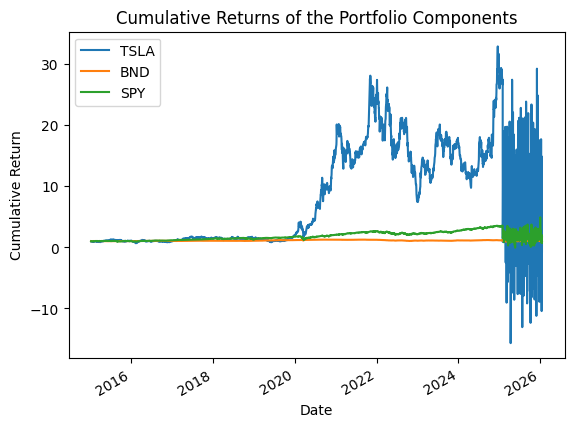

Expected Return: 3356.0657919828036
Expected Volatility: 11165.609313206749
Sharpe Ratio: 0.3005716658931662
Optimal Weights Allocation: {'TSLA': 0.3333333333333333, 'BND': 0.3333333333333333, 'SPY': 0.3333333333333333}


In [5]:
# Visualize the portfolio performance
plt.figure(figsize=(12, 6))
cumulative_returns = (daily_returns + 1).cumprod()
cumulative_returns.plot()
plt.title('Cumulative Returns of the Portfolio Components')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Summary
print("Expected Return:", optimal_return)
print("Expected Volatility:", optimal_volatility)
print("Sharpe Ratio:", optimal_sharpe)
print("Optimal Weights Allocation:", dict(zip(df_combined.columns, optimal_weights)))
